In [142]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import scipy as sp
from scipy.stats import gaussian_kde
from scipy.stats import multivariate_normal, norm, uniform
import seaborn as sns

from tqdm import tqdm

# Bivariate Gaussian

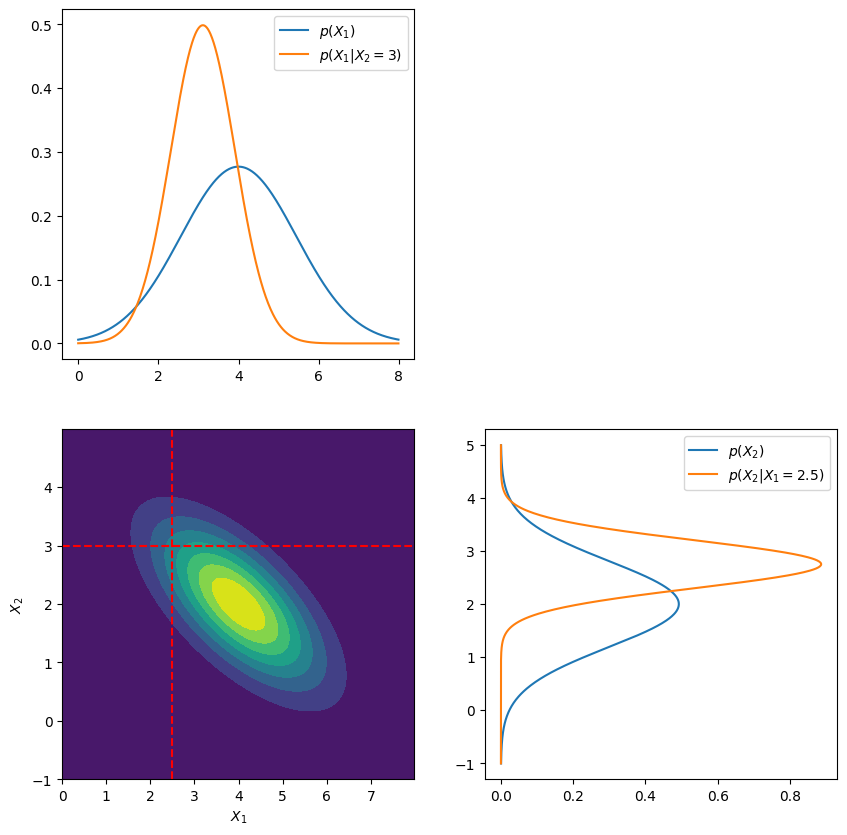

In [16]:
mu = np.array([4, 2])
sigma = np.array([[1.44, -0.72],[-0.72, 0.81]])

#Joint multivariate normal distribution 
joint_mvn = multivariate_normal(mu, sigma)

#marginal distributions
marginal_x = norm(mu[0], sigma[0,0])
marginal_y = norm(mu[1], sigma[1,1])

#conditional distributions
def cond_x(given_y):
    mu_x = mu[0] + sigma[0,1]/sigma[1,1] * (given_y - mu[1])
    sigma_x = sigma[0,0] - sigma[0,1]**2/sigma[1,1]
    return norm(mu_x, sigma_x)

def cond_y(given_x):
    mu_y = mu[1] + sigma[0,1]/sigma[0,0] * (given_x - mu[0])
    sigma_y = sigma[1,1] - sigma[0,1]**2/sigma[0,0]
    return norm(mu_y, sigma_y)

given_y = 3
given_x = 2.5
conditional_x = cond_x(given_y=given_y)
conditional_y = cond_y(given_x=given_x)



#plotting
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(223)
x, y = np.mgrid[0:8:.01, -1:5:.01]
pos = np.dstack((x, y))
contour = ax.contourf(x, y, joint_mvn.pdf(pos),  cmap='viridis')
ax.axvline(given_x, color='r', linestyle='--')
ax.axhline(given_y, color='r', linestyle='--')
# cbar =  fig.colorbar(contour, ax=ax, )
# cbar.set_label(r'$p(X_1, X_2)$')
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_aspect('auto')  

ax = fig.add_subplot(221)
ax.plot(x[:, 0], marginal_x.pdf(x[:, 0]), label=r'$p(X_1)$')
ax.plot(x[:, 0], conditional_x.pdf(x[:, 0]), label=r'$p(X_1|X_2=3)$')
ax.legend()

ax = fig.add_subplot(224)
ax.plot(marginal_y.pdf(y[0, :]),y[0, :], label=r'$p(X_2)$')
ax.plot(conditional_y.pdf(y[0, :]), y[0, :], label=r'$p(X_2|X_1=2.5)$')
ax.legend()


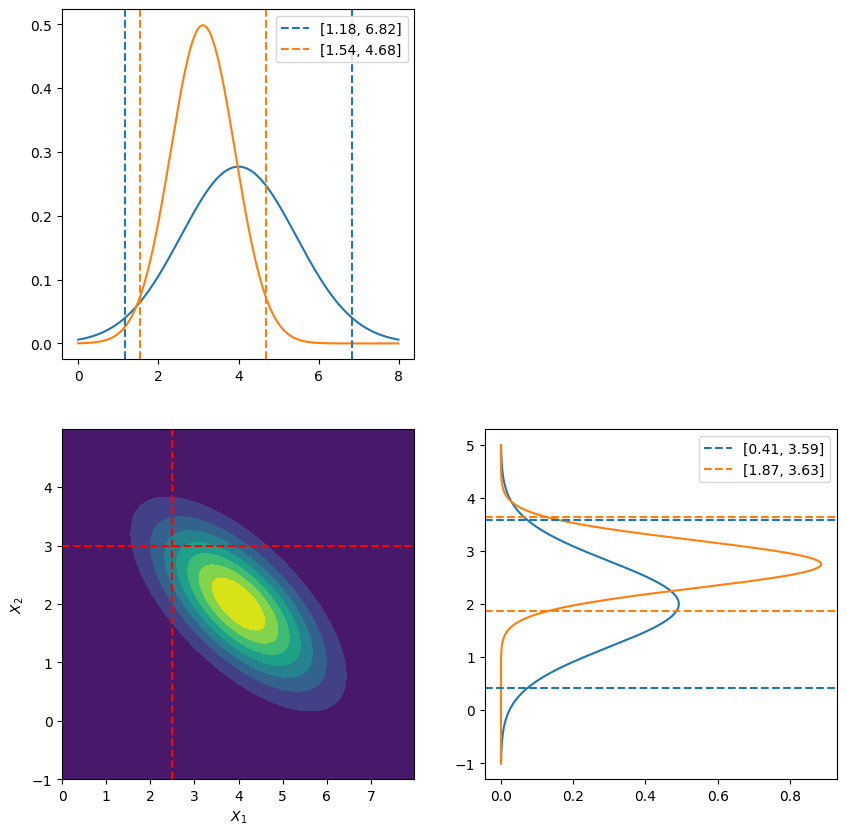

In [15]:
#in order to calculate the confidence interval we will use the Percent Point function
#which is the inverse of the cumulative distribution function

#confidence interval for x 
low_marginal_x = norm.ppf(0.025, loc=marginal_x.mean(), scale=marginal_x.std())
high_marginal_x = norm.ppf(0.975, loc=marginal_x.mean(), scale=marginal_x.std())

low_conditional_x = norm.ppf(0.025, loc=conditional_x.mean(), scale=conditional_x.std())
high_conditional_x = norm.ppf(0.975, loc=conditional_x.mean(), scale=conditional_x.std())

#confidence interval for y
low_marginal_y = norm.ppf(0.025, loc=marginal_y.mean(), scale=marginal_y.std())
high_marginal_y = norm.ppf(0.975, loc=marginal_y.mean(), scale=marginal_y.std())

low_conditional_y = norm.ppf(0.025, loc=conditional_y.mean(), scale=conditional_y.std())
high_conditional_y = norm.ppf(0.975, loc=conditional_y.mean(), scale=conditional_y.std())


#plotting
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(223)
x, y = np.mgrid[0:8:.01, -1:5:.01]
pos = np.dstack((x, y))
contour = ax.contourf(x, y, joint_mvn.pdf(pos),  cmap='viridis')
ax.axvline(given_x, color='r', linestyle='--')
ax.axhline(given_y, color='r', linestyle='--')
# cbar =  fig.colorbar(contour, ax=ax, )
# cbar.set_label(r'$p(X_1, X_2)$')
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')
ax.set_aspect('auto')  

ax = fig.add_subplot(221)
ax.plot(x[:, 0], marginal_x.pdf(x[:, 0]), )
ax.plot(x[:, 0], conditional_x.pdf(x[:, 0]), )
ax.axvline(low_marginal_x, color='tab:blue', linestyle='--', label=f'[{low_marginal_x:.2f}, {high_marginal_x:.2f}]')
ax.axvline(high_marginal_x, color='tab:blue', linestyle='--')
ax.axvline(low_conditional_x, color='tab:orange', linestyle='--', label=f'[{low_conditional_x:.2f}, {high_conditional_x:.2f}]')
ax.axvline(high_conditional_x, color='tab:orange', linestyle='--')
ax.legend()

ax = fig.add_subplot(224)
ax.plot(marginal_y.pdf(y[0, :]),y[0, :], )
ax.plot(conditional_y.pdf(y[0, :]), y[0, :], )
ax.axhline(low_marginal_y, color='tab:blue', linestyle='--', label=f'[{low_marginal_y:.2f}, {high_marginal_y:.2f}]')
ax.axhline(high_marginal_y, color='tab:blue', linestyle='--')
ax.axhline(low_conditional_y, color='tab:orange', linestyle='--', label=f'[{low_conditional_y:.2f}, {high_conditional_y:.2f}]')
ax.axhline(high_conditional_y, color='tab:orange', linestyle='--')  
ax.legend()

When conditioning the standard deviation is always smaller or equal to the standard deviation obtain after marginalization. This is because when you condition over parameters you do not have error propagation effects. 

# 7.a) Draw samples using the Cholesky decomposition of the covariance

In [123]:

eigenvalues = np.linalg.eigvals(sigma)
print(f'The two eigenvalues are: {eigenvalues[0]:.2f} and {eigenvalues[1]:.2f}, so the matrix is positive definite')

L = np.linalg.cholesky(sigma)
print(f' Verify that Cov -  {{L $\cdot$ L^T}} is a zero matrix:{sigma - L@L.T}')

#generate independence sample u ~ N(0, I)
u = np.random.normal(size=(200_000, 2))

#compute the dependent sample x = mu + L@u
samples = mu.reshape(2, 1) + L@u.T
x, y = samples[0, :], samples[1, :]

# Calculate the confidence interval for the samples
low_x = np.quantile(x, 0.025)
high_x = np.quantile(x, 0.975)

low_y = np.quantile(y, 0.025)
high_y = np.quantile(y, 0.975)


The two eigenvalues are: 1.91 and 0.34, so the matrix is positive definite
 Verify that Cov -  {L $\cdot$ L^T} is a zero matrix:[[0. 0.]
 [0. 0.]]


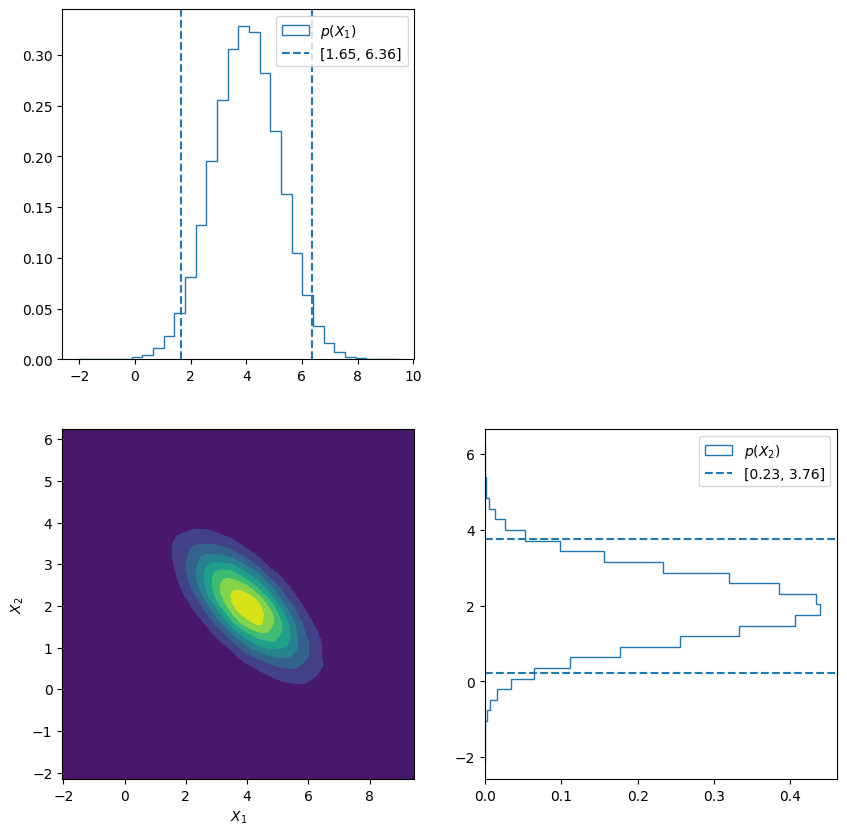

In [124]:
#plotting
xy = np.vstack([x,y])
kde = gaussian_kde(xy)
# Generate grid
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate KDE on grid
f = np.reshape(kde(positions).T, xx.shape)

# Plot filled contour
fig = plt.figure(figsize=(10, 10))
ax =  fig.add_subplot(223)
ax.contourf(xx, yy, f)
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')

ax = fig.add_subplot(221)
ax.hist(x, bins=30, density=True,histtype='step', label=r'$p(X_1)$');
ax.axvline(low_x, color='tab:blue', linestyle='--', label=f'[{low_x:.2f}, {high_x:.2f}]')
ax.axvline(high_x, color='tab:blue', linestyle='--')
ax.legend()

ax = fig.add_subplot(224)
ax.hist(y, bins=30, density=True, histtype='step', orientation='horizontal', label=r'$p(X_2)$');
ax.axhline(low_y, color='tab:blue', linestyle='--', label=f'[{low_y:.2f}, {high_y:.2f}]')
ax.axhline(high_y, color='tab:blue', linestyle='--')
ax.legend()

# 7.b) Draw samples using the Metropolis-Hasting


In [2]:
mu = np.array([4, 2])
sigma = np.array([[1.44, -0.72],[-0.72, 0.81]])

#Joint multivariate normal distribution 
joint_mvn = multivariate_normal(mu, sigma)

In [126]:
class MHsampler():
    def __init__(self):
        self.sigma = None
        self.uniform = sp.stats.uniform()
    def set_sigma(self, sigma):
        self.sigma = sigma
        self.proposal = sp.stats.multivariate_normal(cov=self.sigma*np.eye(2))
    def set_target(self, target):
        self.target = target   
    def sample(self, x0, n):
        x = x0
        samples = []
        for i in tqdm(range(n)):
            self.proposal.mean = x
            x_new = self.proposal.rvs() 
            #acceptance probability used log to avoid numerical issues
            acceptance = np.log(self.target.pdf(x_new)) - np.log(self.target.pdf(x))
            if np.log(self.uniform.rvs()) < acceptance:  
                x = x_new
            samples.append(x)
        self.samples = np.array(samples)
    
    def plot_chain(self, i=0):
        plt.plot(self.samples[:, 0], self.samples[:, 1],  linewidth=0.5, label=f'Chain {i}')
        plt.xlabel(r'$X_1$')
        plt.ylabel(r'$X_2$')
        
    def plot_trace(self, i=0):
        plt.plot(np.log(self.target.pdf(self.samples)), label=f'Chain {i}')
        plt.xlabel('Iteration')
        plt.ylabel('Log(P)')
        

In [127]:
sampler = MHsampler()
sampler.set_sigma(np.array([1, 1]))
sampler.set_target(joint_mvn)
sampler.sample(x0=np.array([10, 10]), n=500)

100%|██████████| 500/500 [00:00<00:00, 3926.80it/s]


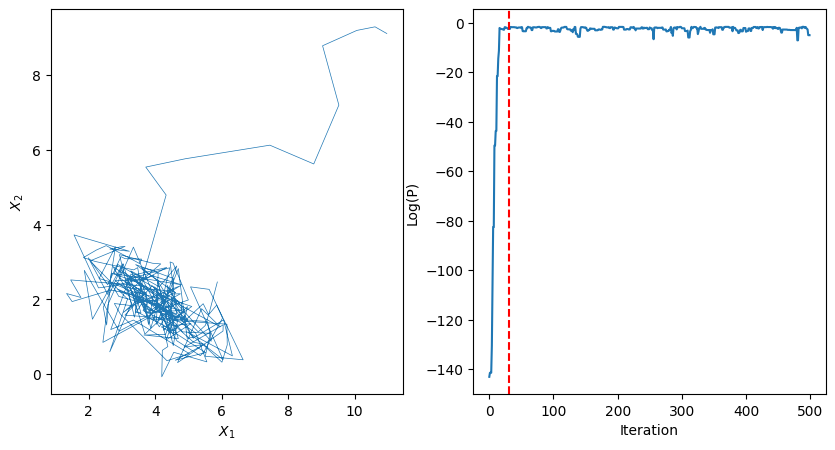

In [128]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
sampler.plot_chain()
ax = fig.add_subplot(122)
sampler.plot_trace()
ax.axvline(30, color='r', linestyle='--')

Text(0, 0.5, '$X_2$')

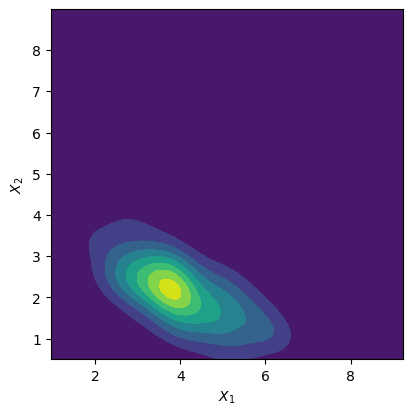

In [98]:
x, y = samples[:, 0], samples[:, 1]
xy = np.vstack([x,y])
kde = gaussian_kde(xy)
# Generate grid
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Evaluate KDE on grid
f = np.reshape(kde(positions).T, xx.shape)

# Plot filled contour
fig = plt.figure(figsize=(10, 10))
ax =  fig.add_subplot(223)
ax.contourf(xx, yy, f)
ax.set_xlabel(r'$X_1$')
ax.set_ylabel(r'$X_2$')

In [159]:
#Running multiple chains in parallel using the Pool function

def run_chain(args):
    chain, x0 = args
    chain.set_sigma(np.array([1, 1]))
    chain.set_target(joint_mvn)
    chain.sample(x0=x0, n=5_000)
    return chain

n_chains = 8
chains = [MHsampler() for _ in range(n_chains)]
list_x0 = np.random.uniform(low=-20, high=20, size=(n_chains, 2))

with Pool(processes=n_chains) as pool:
    chains = pool.map(run_chain, zip(chains, list_x0))



100%|██████████| 5000/5000 [00:01<00:00, 3444.94it/s]


(0.0, 200.0)

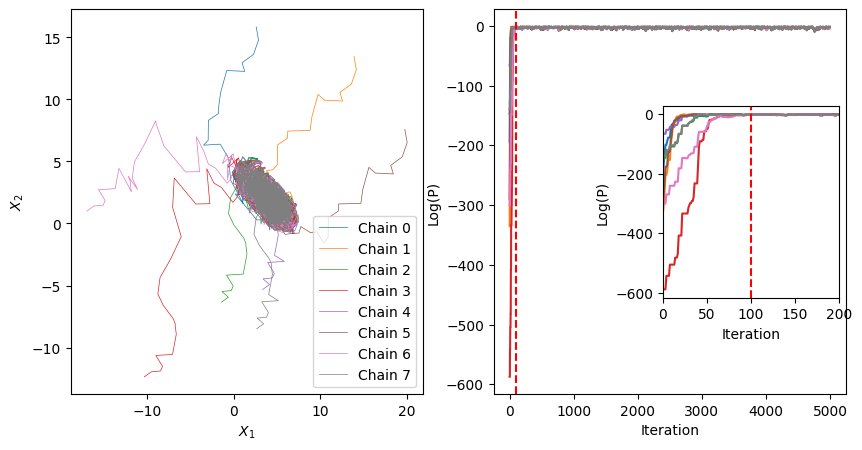

In [162]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
for i, chain in enumerate(chains):
    chain.plot_chain(i)
ax.legend()

ax = fig.add_subplot(122)
for i, chain in enumerate(chains):
    chain.plot_trace(i)
ax.axvline(100, color='r', linestyle='--')

axins = inset_axes(ax, width="50%", height="50%", loc='center right')
for i, chain in enumerate(chains):
    chain.plot_trace(i)
axins.axvline(100, color='r', linestyle='--')
axins.set_xlim(0, 200)  # Set the x-axis limit for the inset


In [188]:
def autocorr(chain, tau):
    n =  len(chain)
    mean = np.mean(chain)
    rho = (1/(n-tau)) * ( np.sum((chain[:n-tau]-mean)*(chain[tau:]-mean), axis=0)/np.sum((chain[:n-tau]-mean)**2, axis=0)  )  
    return rho

def autocorr_time(chain):
    n = len(chain)
    taus = np.arange(1, n//2)
    # return autocorr(chain, 0).shape
    rho = np.array([autocorr(chain, tau) for tau in taus])
    return rho, 1 + 2*np.sum(rho, axis=0)
    
chain_0 = chains[0].samples
rho, aut_time = autocorr_time(chain_0)

   

array([1.49391932, 1.57480027])